# Работа с различными форматами данных и большими файлами

В этой тетрадке рассмотрим:
1. Чтение и запись CSV файлов
2. Работа с Excel файлами
3. JSON и другие форматы
4. Работа с большими данными (chunking, dask, parquet)
5. Оптимизация памяти
6. Лучшие практики работы с данными

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path
import json
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Создание директории для данных
data_dir = Path('sample_data')
data_dir.mkdir(exist_ok=True)

print(f"Рабочая директория: {os.getcwd()}")
print(f"Директория для данных: {data_dir.absolute()}")

Рабочая директория: /Users/ilyamikheev/PycharmProjects/ml_biology
Директория для данных: /Users/ilyamikheev/PycharmProjects/ml_biology/sample_data


## 1. Работа с CSV файлами

CSV (Comma-Separated Values) — самый распространенный формат для обмена табличными данными.

### Преимущества CSV:
- Простой текстовый формат
- Поддерживается всеми инструментами
- Маленький размер
- Легко редактировать

### Недостатки:
- Не хранит типы данных
- Не поддерживает несколько таблиц
- Проблемы с кодировками
- Медленное чтение больших файлов

In [37]:
# Создание примера данных
np.random.seed(42)

dates = pd.date_range('2024-01-01', periods=1000, freq='H')
df_sample = pd.DataFrame({
    'timestamp': dates,
    'temperature': np.random.normal(20, 5, 1000),
    'humidity': np.random.uniform(30, 80, 1000),
    'pressure': np.random.normal(1013, 10, 1000),
    'wind_speed': np.random.exponential(5, 1000),
    'location': np.random.choice(['Moscow', 'London', 'Paris', 'Berlin', 'Rome'], 1000),
    'sensor_id': np.random.randint(1, 11, 1000),
    'status': np.random.choice(['active', 'maintenance', 'error'], 1000, p=[0.8, 0.15, 0.05])
})

print("Пример датасета:")
print(df_sample.head(10))
print(f"\nРазмер: {df_sample.shape}")
print(f"\nТипы данных:\n{df_sample.dtypes}")
print(f"\nИспользование памяти: {df_sample.memory_usage(deep=True).sum() / 1024:.2f} KB")

Пример датасета:
            timestamp  temperature   humidity     pressure  wind_speed  \
0 2024-01-01 00:00:00    22.483571  38.374129  1009.907909    1.481684   
1 2024-01-01 01:00:00    19.308678  35.228392  1005.478436    2.195004   
2 2024-01-01 02:00:00    23.238443  61.821512  1016.191745    5.604201   
3 2024-01-01 03:00:00    27.615149  65.323786  1026.404504    0.323038   
4 2024-01-01 04:00:00    18.829233  31.579307   994.248275    1.181821   
5 2024-01-01 05:00:00    18.829315  76.810612  1014.150261    8.278028   
6 2024-01-01 06:00:00    27.896064  32.598564  1011.398672    0.794521   
7 2024-01-01 07:00:00    23.837174  57.064817  1019.713401    2.097656   
8 2024-01-01 08:00:00    17.652628  65.453026  1015.131966    9.999786   
9 2024-01-01 09:00:00    22.712800  73.548456  1005.480307    0.841651   

  location  sensor_id       status  
0   London          3        error  
1   Moscow          8       active  
2    Paris          7       active  
3   London          

### 1.1. Запись CSV файлов

In [38]:
# Базовая запись
csv_path = data_dir / 'sample_data.csv'
df_sample.to_csv(csv_path, index=False)
print(f"Файл сохранен: {csv_path}")
print(f"Размер файла: {csv_path.stat().st_size / 1024:.2f} KB")

# Запись с различными параметрами
# 1. С другим разделителем
df_sample.to_csv(data_dir / 'sample_semicolon.csv', index=False, sep=';')

# 2. С кодировкой UTF-8 с BOM (для Excel)
df_sample.to_csv(data_dir / 'sample_utf8_bom.csv', index=False, encoding='utf-8-sig')

# 3. Сжатый файл
df_sample.to_csv(data_dir / 'sample_compressed.csv.gz', index=False, compression='gzip')
print(f"Размер сжатого файла: {(data_dir / 'sample_compressed.csv.gz').stat().st_size / 1024:.2f} KB")

# 4. Только определенные колонки
df_sample[['timestamp', 'temperature', 'location']].to_csv(
    data_dir / 'sample_subset.csv', index=False
)

# 5. С форматированием чисел
df_sample.to_csv(data_dir / 'sample_formatted.csv', 
                 index=False, 
                 float_format='%.2f')

print("\nСозданы файлы:")
for file in data_dir.glob('*.csv*'):
    print(f"  {file.name}: {file.stat().st_size / 1024:.2f} KB")

Файл сохранен: sample_data/sample_data.csv
Размер файла: 107.83 KB
Размер сжатого файла: 42.66 KB

Созданы файлы:
  sample_semicolon.csv: 107.83 KB
  large.csv: 1077.66 KB
  sample_compressed.csv.gz: 42.66 KB
  sample_data.csv: 107.83 KB
  sample_utf8_bom.csv: 107.84 KB
  sample_formatted.csv: 59.96 KB
  sample_subset.csv: 44.01 KB


### 1.2. Чтение CSV файлов

In [39]:
# Базовое чтение
df_read = pd.read_csv(csv_path)
print("Базовое чтение:")
print(df_read.head())
print(f"\nТипы данных после чтения:\n{df_read.dtypes}")
print("\n⚠️ Обратите внимание: timestamp стал строкой!")

Базовое чтение:
             timestamp  temperature   humidity     pressure  wind_speed  \
0  2024-01-01 00:00:00    22.483571  38.374129  1009.907909    1.481684   
1  2024-01-01 01:00:00    19.308678  35.228392  1005.478436    2.195004   
2  2024-01-01 02:00:00    23.238443  61.821512  1016.191745    5.604201   
3  2024-01-01 03:00:00    27.615149  65.323786  1026.404504    0.323038   
4  2024-01-01 04:00:00    18.829233  31.579307   994.248275    1.181821   

  location  sensor_id  status  
0   London          3   error  
1   Moscow          8  active  
2    Paris          7  active  
3   London          6  active  
4   London         10  active  

Типы данных после чтения:
timestamp       object
temperature    float64
humidity       float64
pressure       float64
wind_speed     float64
location        object
sensor_id        int64
status          object
dtype: object

⚠️ Обратите внимание: timestamp стал строкой!


In [40]:
# Чтение с указанием типов данных
df_typed = pd.read_csv(
    csv_path,
    dtype={
        'temperature': 'float32',
        'humidity': 'float32',
        'pressure': 'float32',
        'wind_speed': 'float32',
        'location': 'category',
        'sensor_id': 'int16',
        'status': 'category'
    },
    parse_dates=['timestamp']
)

print("Чтение с указанием типов:")
print(df_typed.dtypes)
print(f"\nПамять без типизации: {df_read.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Память с типизацией: {df_typed.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"Экономия: {(1 - df_typed.memory_usage(deep=True).sum() / df_read.memory_usage(deep=True).sum()) * 100:.1f}%")

Чтение с указанием типов:
timestamp      datetime64[ns]
temperature           float32
humidity              float32
pressure              float32
wind_speed            float32
location             category
sensor_id               int16
status               category
dtype: object

Память без типизации: 213.20 KB
Память с типизацией: 28.18 KB
Экономия: 86.8%


In [41]:
# Дополнительные параметры чтения

# 1. Чтение только определенных колонок
df_cols = pd.read_csv(csv_path, usecols=['timestamp', 'temperature', 'location'])
print("Чтение только определенных колонок:")
print(df_cols.head())

# 2. Чтение только первых N строк
df_nrows = pd.read_csv(csv_path, nrows=100)
print(f"\nПрочитано только {len(df_nrows)} строк")

# 3. Пропуск строк
df_skip = pd.read_csv(csv_path, skiprows=range(1, 501))  # пропустить первые 500 строк данных
print(f"\nПропущено 500 строк, прочитано {len(df_skip)} строк")

# 4. Чтение с другим разделителем
df_semicolon = pd.read_csv(data_dir / 'sample_semicolon.csv', sep=';')
print(f"\nЧтение с разделителем ';': {df_semicolon.shape}")

# 5. Чтение сжатого файла (автоматически)
df_compressed = pd.read_csv(data_dir / 'sample_compressed.csv.gz')
print(f"Чтение сжатого файла: {df_compressed.shape}")

# 6. Чтение с обработкой пропущенных значений
df_na = pd.read_csv(csv_path, na_values=['N/A', 'missing', '-'])
print(f"\nОбработка пропусков: {df_na.isnull().sum().sum()} пропусков")

Чтение только определенных колонок:
             timestamp  temperature location
0  2024-01-01 00:00:00    22.483571   London
1  2024-01-01 01:00:00    19.308678   Moscow
2  2024-01-01 02:00:00    23.238443    Paris
3  2024-01-01 03:00:00    27.615149   London
4  2024-01-01 04:00:00    18.829233   London

Прочитано только 100 строк

Пропущено 500 строк, прочитано 500 строк

Чтение с разделителем ';': (1000, 8)
Чтение сжатого файла: (1000, 8)

Обработка пропусков: 0 пропусков


## 2. Работа с Excel файлами

### Преимущества Excel:
- Поддержка нескольких листов
- Форматирование и формулы

### Недостатки:
- Большой размер файлов
- Медленное чтение/запись
- Ограничение на количество строк (1,048,576)
- Требует дополнительные библиотеки

In [42]:
# Установка библиотек для работы с Excel (если нужно)
# !pip install openpyxl xlsxwriter

# Создание нескольких датасетов для примера
df_summary = df_sample.groupby('location').agg({
    'temperature': ['mean', 'std', 'min', 'max'],
    'humidity': ['mean', 'std'],
    'sensor_id': 'count'
}).round(2)
df_summary.columns = ['_'.join(col).strip() for col in df_summary.columns.values]
df_summary = df_summary.reset_index()

print("Сводная статистика по локациям:")
print(df_summary)

Сводная статистика по локациям:
  location  temperature_mean  temperature_std  temperature_min  \
0   Berlin             20.22             4.71            10.98   
1   London             19.65             4.88             3.79   
2   Moscow             20.17             5.46             6.52   
3    Paris             21.02             4.61             9.79   
4     Rome             19.67             4.68             8.94   

   temperature_max  humidity_mean  humidity_std  sensor_id_count  
0            33.16          54.34         14.04              193  
1            32.23          54.52         14.32              233  
2            39.26          55.54         14.81              198  
3            32.87          56.51         14.36              167  
4            31.35          55.30         14.59              209  


In [43]:
# Запись в Excel с несколькими листами
excel_path = data_dir / 'sample_data.xlsx'

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Основные данные
    df_sample.to_excel(writer, sheet_name='Raw Data', index=False)
    
    # Статистика
    df_summary.to_excel(writer, sheet_name='Summary', index=False)
    
    # Данные по каждой локации
    for location in df_sample['location'].unique():
        df_location = df_sample[df_sample['location'] == location]
        df_location.to_excel(writer, sheet_name=location, index=False)

print(f"Excel файл сохранен: {excel_path}")
print(f"Размер файла: {excel_path.stat().st_size / 1024:.2f} KB")

Excel файл сохранен: sample_data/sample_data.xlsx
Размер файла: 157.31 KB


In [44]:
# Чтение из Excel

# 1. Чтение всех листов
excel_file = pd.ExcelFile(excel_path)
print("Листы в Excel файле:")
print(excel_file.sheet_names)

# 2. Чтение конкретного листа
df_from_excel = pd.read_excel(excel_path, sheet_name='Raw Data')
print(f"\nПрочитан лист 'Raw Data': {df_from_excel.shape}")
print(df_from_excel.head())

# 3. Чтение нескольких листов сразу
dfs_dict = pd.read_excel(excel_path, sheet_name=['Summary', 'Moscow', 'London'])
print(f"\nПрочитано {len(dfs_dict)} листов")
for sheet_name, df in dfs_dict.items():
    print(f"  {sheet_name}: {df.shape}")

# 4. Чтение всех листов
all_sheets = pd.read_excel(excel_path, sheet_name=None)
print(f"\nВсего листов: {len(all_sheets)}")


Всего листов: 7


In [45]:
# Запись с форматированием (xlsxwriter)
excel_formatted = data_dir / 'formatted_report.xlsx'

with pd.ExcelWriter(excel_formatted, engine='xlsxwriter') as writer:
    df_summary.to_excel(writer, sheet_name='Report', index=False, startrow=1)
    
    # Получение объектов workbook и worksheet
    workbook = writer.book
    worksheet = writer.sheets['Report']
    
    # Создание форматов
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#4472C4',
        'font_color': 'white',
        'border': 1
    })
    
    title_format = workbook.add_format({
        'bold': True,
        'font_size': 14,
        'font_color': '#1F4E78'
    })
    
    number_format = workbook.add_format({'num_format': '0.00'})
    
    # Добавление заголовка
    worksheet.write('A1', 'Weather Data Summary Report', title_format)
    
    # Форматирование заголовков колонок
    for col_num, value in enumerate(df_summary.columns.values):
        worksheet.write(1, col_num, value, header_format)
    
    # Автоматическая ширина колонок
    for i, col in enumerate(df_summary.columns):
        max_len = max(df_summary[col].astype(str).apply(len).max(), len(col)) + 2
        worksheet.set_column(i, i, max_len)

print(f"Отформатированный Excel файл сохранен: {excel_formatted}")

Отформатированный Excel файл сохранен: sample_data/formatted_report.xlsx


## 3. Работа с другими форматами

### 3.1. JSON

In [46]:
# Создание данных для JSON
json_data = [
    {
        'id': i,
        'name': f'Sensor_{i}',
        'location': np.random.choice(['Moscow', 'London', 'Paris']),
        'readings': [
            {
                'timestamp': (datetime.now() - timedelta(hours=j)).isoformat(),
                'temperature': round(np.random.normal(20, 5), 2),
                'humidity': round(np.random.uniform(30, 80), 2)
            }
            for j in range(5)
        ]
    }
    for i in range(10)
]

# Запись JSON
json_path = data_dir / 'sensors.json'
with open(json_path, 'w') as f:
    json.dump(json_data, f, indent=2)

print("Пример JSON структуры:")
print(json.dumps(json_data[0], indent=2))

Пример JSON структуры:
{
  "id": 0,
  "name": "Sensor_0",
  "location": "Moscow",
  "readings": [
    {
      "timestamp": "2026-02-06T18:24:12.837433",
      "temperature": 21.35,
      "humidity": 54.59
    },
    {
      "timestamp": "2026-02-06T17:24:12.837463",
      "temperature": 18.09,
      "humidity": 69.21
    },
    {
      "timestamp": "2026-02-06T16:24:12.837477",
      "temperature": 16.07,
      "humidity": 68.28
    },
    {
      "timestamp": "2026-02-06T15:24:12.837488",
      "temperature": 20.79,
      "humidity": 33.49
    },
    {
      "timestamp": "2026-02-06T14:24:12.837491",
      "temperature": 13.53,
      "humidity": 67.62
    }
  ]
}


In [47]:
# Чтение JSON в DataFrame

# 1. Простое чтение
df_json = pd.read_json(json_path)
print("Чтение JSON (простое):")
print(df_json.head())
print(f"\nТип колонки 'readings': {type(df_json['readings'][0])}")

# 2. Нормализация вложенных данных
df_normalized = pd.json_normalize(
    json_data,
    record_path='readings',
    meta=['id', 'name', 'location'],
    meta_prefix='sensor_'
)

print("\nНормализованные данные:")
print(df_normalized.head(10))
print(f"\nРазмер: {df_normalized.shape}")

Чтение JSON (простое):
   id      name location                                           readings
0   0  Sensor_0   Moscow  [{'timestamp': '2026-02-06T18:24:12.837433', '...
1   1  Sensor_1   London  [{'timestamp': '2026-02-06T18:24:12.837515', '...
2   2  Sensor_2    Paris  [{'timestamp': '2026-02-06T18:24:12.837548', '...
3   3  Sensor_3    Paris  [{'timestamp': '2026-02-06T18:24:12.837568', '...
4   4  Sensor_4   London  [{'timestamp': '2026-02-06T18:24:12.837585', '...

Тип колонки 'readings': <class 'list'>

Нормализованные данные:
                    timestamp  temperature  humidity sensor_id sensor_name  \
0  2026-02-06T18:24:12.837433        21.35     54.59         0    Sensor_0   
1  2026-02-06T17:24:12.837463        18.09     69.21         0    Sensor_0   
2  2026-02-06T16:24:12.837477        16.07     68.28         0    Sensor_0   
3  2026-02-06T15:24:12.837488        20.79     33.49         0    Sensor_0   
4  2026-02-06T14:24:12.837491        13.53     67.62         0    

In [48]:
# Запись DataFrame в JSON
df_sample_small = df_sample.head(100)

# Различные ориентации
orientations = ['records', 'index', 'columns', 'values', 'split', 'table']

for orient in orientations:
    output_path = data_dir / f'sample_{orient}.json'
    df_sample_small.to_json(output_path, orient=orient, date_format='iso', indent=2)
    size = output_path.stat().st_size / 1024
    print(f"Orient '{orient}': {size:.2f} KB")

Orient 'records': 23.79 KB
Orient 'index': 24.27 KB
Orient 'columns': 17.91 KB
Orient 'values': 14.71 KB
Orient 'split': 17.61 KB
Orient 'table': 28.22 KB


### 3.2. Parquet

**Parquet** — эффективный колоночный формат для хранения больших данных.

#### Преимущества:
- Эффективное сжатие
- Быстрое чтение
- Сохраняет типы данных
- Поддерживает сложные типы
- Колоночное хранение (быстрая выборка колонок)

#### Недостатки:
- Не человекочитаемый
- Требует библиотеку pyarrow/fastparquet

In [49]:
# !pip install pyarrow

In [50]:
# Запись в Parquet
parquet_path = data_dir / 'sample_data.parquet'
df_sample.to_parquet(parquet_path, engine='pyarrow', compression='snappy')

print("Сравнение размеров файлов:")
print(f"CSV: {csv_path.stat().st_size / 1024:.2f} KB")
print(f"CSV (gzip): {(data_dir / 'sample_compressed.csv.gz').stat().st_size / 1024:.2f} KB")
print(f"Excel: {excel_path.stat().st_size / 1024:.2f} KB")
print(f"Parquet: {parquet_path.stat().st_size / 1024:.2f} KB")

# Чтение из Parquet
df_parquet = pd.read_parquet(parquet_path)
print(f"\nДанные прочитаны: {df_parquet.shape}")
print(f"Типы данных сохранены: {df_parquet.dtypes['timestamp']}")

Сравнение размеров файлов:
CSV: 107.83 KB
CSV (gzip): 42.66 KB
Excel: 157.31 KB
Parquet: 51.94 KB

Данные прочитаны: (1000, 8)
Типы данных сохранены: datetime64[ns]


In [51]:
# Сравнение скорости чтения
import time

# Создание большого датасета для теста
df_large = pd.concat([df_sample] * 10, ignore_index=True)
df_large.to_csv(data_dir / 'large.csv', index=False)
df_large.to_parquet(data_dir / 'large.parquet', engine='pyarrow')

# Тестирование скорости чтения
print("Тест скорости чтения (10,000 строк):\n")

# CSV
start = time.time()
df_test = pd.read_csv(data_dir / 'large.csv')
csv_time = time.time() - start
print(f"CSV: {csv_time:.4f} секунд")

# Parquet
start = time.time()
df_test = pd.read_parquet(data_dir / 'large.parquet')
parquet_time = time.time() - start
print(f"Parquet: {parquet_time:.4f} секунд")

print(f"\nParquet быстрее в {csv_time / parquet_time:.1f}x раз!")

Parquet: 0.0024 секунд

Parquet быстрее в 2.3x раз!


### 3.3. HDF5

**HDF5** (Hierarchical Data Format) — формат для хранения больших объемов научных данных.

In [52]:
!pip install tables


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [53]:
# Запись в HDF5
hdf_path = data_dir / 'sample_data.h5'

# Запись нескольких датасетов
with pd.HDFStore(hdf_path, mode='w') as store:
    store['raw_data'] = df_sample
    store['summary'] = df_summary
    store['metadata'] = pd.DataFrame({
        'key': ['created', 'version', 'source'],
        'value': [datetime.now().isoformat(), '1.0', 'sensors']
    })

print(f"HDF5 файл создан: {hdf_path}")
print(f"Размер: {hdf_path.stat().st_size / 1024:.2f} KB")

# Чтение из HDF5
with pd.HDFStore(hdf_path, mode='r') as store:
    print(f"\nДоступные ключи: {store.keys()}")
    df_from_hdf = store['raw_data']
    print(f"Прочитано: {df_from_hdf.shape}")

HDF5 файл создан: sample_data/sample_data.h5
Размер: 3174.35 KB

Доступные ключи: ['/metadata', '/raw_data', '/summary']
Прочитано: (1000, 8)


## 4. Работа с большими файлами

### Проблемы при работе с большими данными:
- Не помещаются в память
- Долгое чтение
- Медленная обработка

### Решения:
1. **Chunking** — чтение по частям
2. **Оптимизация типов данных**
3. **Выборка колонок**
4. **Dask** — параллельная обработка
5. **Sampling** — работа с выборкой

### 4.1. Chunking — чтение по частям

In [54]:
# Создание "большого" файла для демонстрации
large_csv = data_dir / 'very_large.csv'

# Генерируем файл по частям, чтобы не загружать память
print("Создание большого CSV файла...")
chunk_size = 10000
n_chunks = 10

for i in range(n_chunks):
    df_chunk = pd.DataFrame({
        'id': range(i * chunk_size, (i + 1) * chunk_size),
        'value1': np.random.randn(chunk_size),
        'value2': np.random.randn(chunk_size),
        'value3': np.random.randn(chunk_size),
        'category': np.random.choice(['A', 'B', 'C', 'D'], chunk_size),
        'timestamp': pd.date_range('2024-01-01', periods=chunk_size, freq='min')
    })
    
    # Добавляем в файл
    if i == 0:
        df_chunk.to_csv(large_csv, index=False, mode='w')
    else:
        df_chunk.to_csv(large_csv, index=False, mode='a', header=False)

total_rows = chunk_size * n_chunks
file_size_mb = large_csv.stat().st_size / (1024 * 1024)
print(f"Создан файл с {total_rows:,} строками")
print(f"Размер файла: {file_size_mb:.2f} MB")

Создан файл с 100,000 строками
Размер файла: 8.28 MB


In [55]:
# Чтение по чанкам
print("Чтение файла по частям...\n")

chunk_size = 10000
total_sum = 0
row_count = 0
category_counts = {'A': 0, 'B': 0, 'C': 0, 'D': 0}

# Итерация по чанкам
for i, chunk in enumerate(pd.read_csv(large_csv, chunksize=chunk_size)):
    # Обработка каждого чанка
    total_sum += chunk['value1'].sum()
    row_count += len(chunk)
    
    # Агрегация категорий
    for cat in category_counts.keys():
        category_counts[cat] += (chunk['category'] == cat).sum()
    
    if (i + 1) % 3 == 0:
        print(f"Обработано {row_count:,} строк...")

print(f"\nВсего обработано: {row_count:,} строк")
print(f"Сумма value1: {total_sum:.2f}")
print(f"Среднее value1: {total_sum / row_count:.4f}")
print(f"\nРаспределение категорий:")
for cat, count in category_counts.items():
    print(f"  {cat}: {count:,} ({count/row_count*100:.1f}%)")

Чтение файла по частям...

Обработано 30,000 строк...
Обработано 60,000 строк...
Обработано 90,000 строк...

Всего обработано: 100,000 строк
Сумма value1: -35.34
Среднее value1: -0.0004

Распределение категорий:
  A: 25,210 (25.2%)
  B: 24,969 (25.0%)
  C: 24,994 (25.0%)
  D: 24,827 (24.8%)


In [56]:
# Фильтрация при чтении по чанкам
print("Фильтрация больших данных...\n")

filtered_chunks = []
chunk_size = 10000

for chunk in pd.read_csv(large_csv, chunksize=chunk_size):
    # Применяем фильтр к каждому чанку
    filtered = chunk[(chunk['category'] == 'A') & (chunk['value1'] > 0)]
    filtered_chunks.append(filtered)

# Объединяем отфильтрованные чанки
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

print(f"Результат фильтрации:")
print(f"Исходных строк: {total_rows:,}")
print(f"После фильтрации: {len(df_filtered):,}")
print(f"Процент отобранных: {len(df_filtered)/total_rows*100:.2f}%")
print(f"\nПервые строки:")
print(df_filtered.head())

Результат фильтрации:
Исходных строк: 100,000
После фильтрации: 12,690
Процент отобранных: 12.69%

Первые строки:
   id    value1    value2    value3 category            timestamp
0   8  0.899912 -1.640813  1.313893        A  2024-01-01 00:08:00
1  31  0.110321 -0.613013 -1.321056        A  2024-01-01 00:31:00
2  37  0.078489  0.556911  0.945663        A  2024-01-01 00:37:00
3  40  0.292277  1.500109 -0.082709        A  2024-01-01 00:40:00
4  42  0.269731  0.740353 -1.680704        A  2024-01-01 00:42:00


### 4.2. Оптимизация использования памяти

In [57]:
def optimize_dtypes(df):
    """
    Оптимизация типов данных для экономии памяти
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f'Использование памяти: {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Категориальные данные
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f'Использование памяти после оптимизации: {end_mem:.2f} MB')
    print(f'Уменьшение: {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

# Тест оптимизации
df_test = pd.read_csv(large_csv, nrows=50000)
print("До оптимизации:")
print(df_test.dtypes)
print(f"\nПамять: {df_test.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

df_optimized = optimize_dtypes(df_test.copy())
print("\nПосле оптимизации:")
print(df_optimized.dtypes)

До оптимизации:
id             int64
value1       float64
value2       float64
value3       float64
category      object
timestamp     object
dtype: object

Память: 7.15 MB

Использование памяти: 7.15 MB
Использование памяти после оптимизации: 1.52 MB
Уменьшение: 78.7%

После оптимизации:
id              int32
value1        float16
value2        float16
value3        float16
category     category
timestamp    category
dtype: object


### 4.3. Работа с Dask для больших данных

**Dask** — библиотека для параллельных вычислений, позволяющая работать с данными, превышающими размер памяти.

In [66]:
!pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [dask]

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [67]:
try:
    import dask.dataframe as dd
    
    print("Работа с Dask:\n")
    
    # Чтение файла с Dask
    ddf = dd.read_csv(large_csv, blocksize='10MB')
    
    print(f"Dask DataFrame создан")
    print(f"Количество партиций: {ddf.npartitions}")
    print(f"Колонки: {ddf.columns.tolist()}")
    
    # Ленивые вычисления - только создаем план
    result = ddf.groupby('category')['value1'].mean()
    print("\nЛенивое вычисление создано (не выполнено)")
    
    # Выполнение вычислений
    print("\nВыполнение вычислений...")
    computed_result = result.compute()
    print("\nСреднее по категориям:")
    print(computed_result)
    
    # Более сложная агрегация
    summary = ddf.groupby('category').agg({
        'value1': ['mean', 'std', 'count'],
        'value2': ['mean', 'std']
    }).compute()
    
    print("\nСводная статистика:")
    print(summary)
    
except ImportError:
    print("Dask не установлен. Установите: pip install dask[complete]")

Работа с Dask:

Dask DataFrame создан
Количество партиций: 1
Колонки: ['id', 'value1', 'value2', 'value3', 'category', 'timestamp']

Ленивое вычисление создано (не выполнено)

Выполнение вычислений...

Среднее по категориям:
category
A    0.006600
B   -0.009862
C    0.001176
D    0.000610
Name: value1, dtype: float64

Сводная статистика:
            value1                     value2          
              mean       std  count      mean       std
category                                               
D         0.000610  0.994389  24827  0.003819  1.002982
B        -0.009862  0.995462  24969  0.003195  0.993803
A         0.006600  1.000875  25210 -0.001908  0.999639
C         0.001176  0.994173  24994 -0.000461  0.996316


### 4.4. Sampling — работа с выборкой

In [68]:
# Чтение случайной выборки из большого файла
print("Методы работы с выборкой:\n")

# Метод 1: skiprows с вероятностью
n = sum(1 for line in open(large_csv)) - 1  # минус заголовок
s = 10000  # желаемый размер выборки
skip = sorted(np.random.choice(range(1, n+1), n-s, replace=False))

df_sample = pd.read_csv(large_csv, skiprows=skip)
print(f"Метод 1 (skiprows): {len(df_sample)} строк")

# Метод 2: чтение всего файла и sample (не рекомендуется для очень больших файлов)
df_full = pd.read_csv(large_csv)
df_sample2 = df_full.sample(n=10000, random_state=42)
print(f"Метод 2 (sample): {len(df_sample2)} строк")

# Метод 3: вероятностная выборка при чтении по чанкам
sample_ratio = 0.1  # 10% данных
samples = []

for chunk in pd.read_csv(large_csv, chunksize=10000):
    sample = chunk.sample(frac=sample_ratio)
    samples.append(sample)

df_sample3 = pd.concat(samples, ignore_index=True)
print(f"Метод 3 (chunked sampling): {len(df_sample3)} строк")

# Стратифицированная выборка
df_stratified = df_full.groupby('category', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
)
print(f"\nСтратифицированная выборка: {len(df_stratified)} строк")
print("Распределение категорий:")
print(df_stratified['category'].value_counts(normalize=True))

Методы работы с выборкой:

Метод 1 (skiprows): 10000 строк
Метод 2 (sample): 10000 строк
Метод 3 (chunked sampling): 10000 строк

Стратифицированная выборка: 10000 строк
Распределение категорий:
category
A    0.2521
C    0.2499
B    0.2497
D    0.2483
Name: proportion, dtype: float64


## 5. Лучшие практики работы с данными

### 5.1. Выбор формата

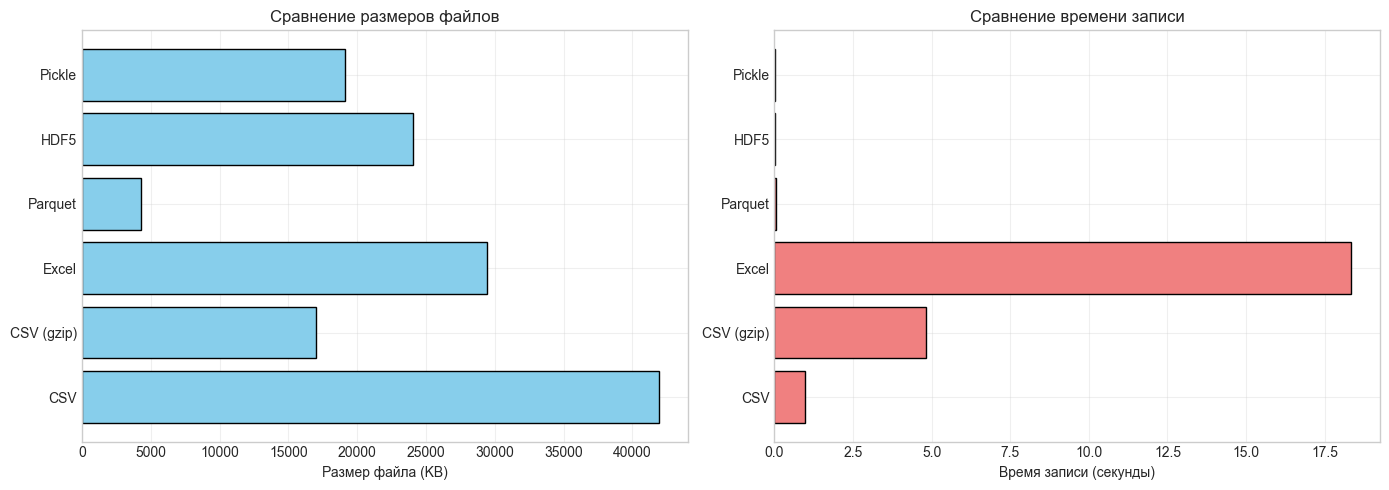

In [69]:
# Сравнение форматов
import time

# Подготовка данных
df_compare = pd.concat([df_sample] * 50, ignore_index=True)
print(f"Тестовый датасет: {df_compare.shape}\n")

formats = {
    'CSV': lambda: df_compare.to_csv(data_dir / 'compare.csv', index=False),
    'CSV (gzip)': lambda: df_compare.to_csv(data_dir / 'compare.csv.gz', index=False, compression='gzip'),
    'Excel': lambda: df_compare.to_excel(data_dir / 'compare.xlsx', index=False),
    'Parquet': lambda: df_compare.to_parquet(data_dir / 'compare.parquet'),
    'HDF5': lambda: df_compare.to_hdf(data_dir / 'compare.h5', key='data', mode='w'),
    'Pickle': lambda: df_compare.to_pickle(data_dir / 'compare.pkl'),
}

results = []

for name, write_func in formats.items():
    # Запись
    start = time.time()
    write_func()
    write_time = time.time() - start
    
    # Размер файла
    file_ext = {
        'CSV': '.csv',
        'CSV (gzip)': '.csv.gz',
        'Excel': '.xlsx',
        'Parquet': '.parquet',
        'HDF5': '.h5',
        'Pickle': '.pkl'
    }
    file_path = data_dir / f'compare{file_ext[name]}'
    file_size = file_path.stat().st_size / 1024  # KB
    
    results.append({
        'Format': name,
        'Write Time (s)': round(write_time, 3),
        'File Size (KB)': round(file_size, 2)
    })

df_results = pd.DataFrame(results)
print("Сравнение форматов:\n")
print(df_results.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Размер файлов
axes[0].barh(df_results['Format'], df_results['File Size (KB)'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Размер файла (KB)')
axes[0].set_title('Сравнение размеров файлов')
axes[0].grid(True, alpha=0.3)

# Время записи
axes[1].barh(df_results['Format'], df_results['Write Time (s)'], color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Время записи (секунды)')
axes[1].set_title('Сравнение времени записи')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2. Рекомендации по выбору формата

| Формат | Когда использовать | Преимущества | Недостатки |
|--------|-------------------|--------------|------------|
| **CSV** | Обмен данными, простые таблицы | Универсальность, читаемость | Размер, медленное чтение |
| **CSV (gzip)** | Архивирование, передача | Малый размер | Медленное чтение |
| **Excel** | Бизнес-отчеты, презентации | Форматирование, несколько листов | Размер, скорость |
| **Parquet** | Big Data, аналитика | Сжатие, скорость, типы данных | Не читаем человеком |
| **HDF5** | Научные данные, иерархии | Гибкость, сжатие | Сложность |
| **Pickle** | Временное хранение Python объектов | Скорость, полная сериализация | Только Python |
| **JSON** | API, конфигурации | Читаемость, структуры | Размер |

### 5.3. Общие рекомендации

1. **Для анализа данных**: Parquet или HDF5
2. **Для обмена**: CSV или JSON
3. **Для отчетов**: Excel
4. **Для архивирования**: CSV.gz или Parquet
5. **Для временных файлов**: Pickle

## 6. Практические советы

### 6.1. Разведочный анализ больших файлов

In [61]:
def quick_analysis(file_path, n_rows=10000):
    """
    Быстрый анализ большого файла без полной загрузки в память
    """
    print(f"Анализ файла: {file_path}\n")
    
    # 1. Чтение первых строк
    df_head = pd.read_csv(file_path, nrows=n_rows)
    
    print("=" * 60)
    print("1. СТРУКТУРА ДАННЫХ")
    print("=" * 60)
    print(f"Первые {n_rows} строк прочитаны")
    print(f"Колонки: {list(df_head.columns)}")
    print(f"\nТипы данных:\n{df_head.dtypes}")
    
    # 2. Подсчет общего количества строк
    total_rows = sum(1 for _ in open(file_path)) - 1
    print(f"\nВсего строк в файле: {total_rows:,}")
    
    # 3. Базовая статистика
    print("\n" + "=" * 60)
    print("2. СТАТИСТИКА (на выборке)")
    print("=" * 60)
    print(df_head.describe())
    
    # 4. Пропущенные значения
    print("\n" + "=" * 60)
    print("3. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    print("=" * 60)
    missing = df_head.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("Пропущенных значений не обнаружено")
    
    # 5. Уникальные значения для категориальных данных
    print("\n" + "=" * 60)
    print("4. УНИКАЛЬНЫЕ ЗНАЧЕНИЯ")
    print("=" * 60)
    for col in df_head.select_dtypes(include=['object']).columns:
        n_unique = df_head[col].nunique()
        print(f"{col}: {n_unique} уникальных значений")
        if n_unique < 10:
            print(f"  Значения: {df_head[col].unique().tolist()}")
    
    # 6. Оценка памяти
    print("\n" + "=" * 60)
    print("5. ИСПОЛЬЗОВАНИЕ ПАМЯТИ")
    print("=" * 60)
    memory_mb = df_head.memory_usage(deep=True).sum() / 1024**2
    estimated_full_mb = memory_mb * (total_rows / n_rows)
    print(f"Память для выборки: {memory_mb:.2f} MB")
    print(f"Оценка для всего файла: {estimated_full_mb:.2f} MB")
    
    return df_head

# Применение
df_analysis = quick_analysis(large_csv, n_rows=10000)

Анализ файла: sample_data/very_large.csv

1. СТРУКТУРА ДАННЫХ
Первые 10000 строк прочитаны
Колонки: ['id', 'value1', 'value2', 'value3', 'category', 'timestamp']

Типы данных:
id             int64
value1       float64
value2       float64
value3       float64
category      object
timestamp     object
dtype: object

Всего строк в файле: 100,000

2. СТАТИСТИКА (на выборке)
                id        value1        value2        value3
count  10000.00000  10000.000000  10000.000000  10000.000000
mean    4999.50000     -0.001628      0.004139     -0.005216
std     2886.89568      0.995794      0.988368      1.008093
min        0.00000     -4.054050     -3.489780     -3.781026
25%     2499.75000     -0.686453     -0.676034     -0.676434
50%     4999.50000     -0.005261      0.010043     -0.010098
75%     7499.25000      0.665435      0.679302      0.671097
max     9999.00000      3.599467      3.938503      3.809165

3. ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
Пропущенных значений не обнаружено

4. УНИКАЛЬНЫЕ ЗН

### 6.2. Pipeline для обработки данных

In [62]:
class DataPipeline:
    """
    Пайплайн для эффективной обработки больших файлов
    """
    
    def __init__(self, input_file, output_file, chunk_size=10000):
        self.input_file = input_file
        self.output_file = output_file
        self.chunk_size = chunk_size
        self.transforms = []
    
    def add_transform(self, func, name=None):
        """Добавить трансформацию"""
        self.transforms.append((name or func.__name__, func))
        return self
    
    def run(self, verbose=True):
        """Выполнить пайплайн"""
        if verbose:
            print(f"Запуск пайплайна: {self.input_file} → {self.output_file}")
            print(f"Трансформации: {[name for name, _ in self.transforms]}\n")
        
        processed_chunks = 0
        total_rows = 0
        
        # Чтение и обработка по чанкам
        for i, chunk in enumerate(pd.read_csv(self.input_file, chunksize=self.chunk_size)):
            # Применение трансформаций
            for name, transform in self.transforms:
                chunk = transform(chunk)
            
            # Запись результата
            if i == 0:
                chunk.to_csv(self.output_file, index=False, mode='w')
            else:
                chunk.to_csv(self.output_file, index=False, mode='a', header=False)
            
            processed_chunks += 1
            total_rows += len(chunk)
            
            if verbose and processed_chunks % 5 == 0:
                print(f"Обработано чанков: {processed_chunks}, строк: {total_rows:,}")
        
        if verbose:
            print(f"\n✓ Завершено! Обработано {total_rows:,} строк")
        
        return total_rows

# Пример использования
def filter_positive(df):
    """Фильтр: оставить только положительные value1"""
    return df[df['value1'] > 0]

def add_features(df):
    """Добавить новые признаки"""
    df['value_sum'] = df['value1'] + df['value2']
    df['value_product'] = df['value1'] * df['value2']
    return df

def categorize_values(df):
    """Категоризация значений"""
    df['value1_category'] = pd.cut(df['value1'], 
                                     bins=[-np.inf, 0, 1, np.inf], 
                                     labels=['low', 'medium', 'high'])
    return df

# Создание и запуск пайплайна
pipeline = DataPipeline(
    input_file=large_csv,
    output_file=data_dir / 'processed_data.csv',
    chunk_size=10000
)

pipeline.add_transform(filter_positive, 'Фильтрация')
pipeline.add_transform(add_features, 'Добавление признаков')
pipeline.add_transform(categorize_values, 'Категоризация')

result = pipeline.run(verbose=True)

# Проверка результата
df_result = pd.read_csv(data_dir / 'processed_data.csv', nrows=10)
print("\nРезультат обработки:")
print(df_result)

Обработано чанков: 10, строк: 49,940

✓ Завершено! Обработано 49,940 строк

Результат обработки:
   id    value1    value2    value3 category            timestamp  value_sum  \
0   1  0.845797 -0.187511  1.082951        D  2024-01-01 00:01:00   0.658286   
1   2  0.435330 -1.770136  0.228907        B  2024-01-01 00:02:00  -1.334806   
2   4  0.501859  0.318341 -0.774442        D  2024-01-01 00:04:00   0.820200   
3   6  0.064128  0.439883 -3.091996        D  2024-01-01 00:06:00   0.504011   
4   8  0.899912 -1.640813  1.313893        A  2024-01-01 00:08:00  -0.740901   
5   9  0.540322 -1.056303  0.068022        C  2024-01-01 00:09:00  -0.515981   
6  13  0.135656 -0.402308  0.986904        C  2024-01-01 00:13:00  -0.266651   
7  17  1.625875 -0.903400  0.214573        B  2024-01-01 00:17:00   0.722476   
8  19  1.082163 -0.238061 -0.340158        D  2024-01-01 00:19:00   0.844101   
9  21  1.239578 -1.119038 -0.241929        B  2024-01-01 00:21:00   0.120539   

   value_product value

## 7. Резюме

### Ключевые выводы:

1. **Форматы данных**:
   - CSV — универсален, но не оптимален для больших данных
   - Parquet — лучший выбор для аналитики
   - Excel — для бизнес-отчетов
   - JSON — для API и конфигураций

2. **Оптимизация памяти**:
   - Используйте правильные типы данных
   - Конвертируйте строки в категории
   - Используйте float32 вместо float64 где возможно
   - Экономия памяти может достигать 50-70%

3. **Работа с большими файлами**:
   - Chunking для файлов, не помещающихся в память
   - Dask для параллельной обработки
   - Sampling для разведочного анализа
   - Parquet для быстрого чтения колонок

4. **Лучшие практики**:
   - Всегда указывайте типы данных при чтении
   - Используйте сжатие для хранения
   - Читайте только нужные колонки
   - Профилируйте использование памяти

5. **Выбор инструментов**:
   - Pandas — до ~1GB данных в памяти
   - Dask — для данных > RAM
   - Chunking — когда нужна полная обработка
   - Sampling — для быстрого анализа

### Чеклист работы с данными:

- [ ] Оценить размер данных
- [ ] Выбрать подходящий формат
- [ ] Определить необходимые колонки
- [ ] Указать типы данных
- [ ] Решить: полное чтение или chunking
- [ ] Оптимизировать память
- [ ] Использовать сжатие при сохранении
- [ ] Документировать процесс обработки

In [63]:
# Очистка временных файлов (опционально)
import shutil

print("Созданные файлы:")
for file in data_dir.glob('*'):
    size = file.stat().st_size / 1024
    print(f"  {file.name}: {size:.2f} KB")

# Раскомментируйте для удаления временных файлов
# shutil.rmtree(data_dir)
# print("\nВременные файлы удалены")

Созданные файлы:
  compare.xlsx: 29450.51 KB
  sample_semicolon.csv: 107.83 KB
  large.csv: 1077.66 KB
  sample_columns.json: 17.91 KB
  sample_index.json: 24.27 KB
  compare.csv: 41883.25 KB
  sample_split.json: 17.61 KB
  sample_compressed.csv.gz: 42.66 KB
  compare.parquet: 4304.64 KB
  sample_data.csv: 107.83 KB
  sample_table.json: 28.22 KB
  sensors.json: 6.97 KB
  large.parquet: 56.44 KB
  processed_data.csv: 6378.57 KB
  sample_records.json: 23.79 KB
  sample_data.xlsx: 157.31 KB
  sample_utf8_bom.csv: 107.84 KB
  formatted_report.xlsx: 5.79 KB
  sample_data.h5: 3174.35 KB
  sample_formatted.csv: 59.96 KB
  sample_data.parquet: 51.94 KB
  very_large.csv: 8474.65 KB
  sample_values.json: 14.71 KB
  sample_subset.csv: 44.01 KB
  compare.h5: 24027.58 KB
  compare.pkl: 19099.97 KB
  compare.csv.gz: 17016.78 KB
